In [1]:
# import nacessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt as pw
import wavelet_filter as filter
from ecg_gudb_database import GUDb
from qrs_detection import QRS_detection as detect
from hrv import HRV

In [2]:
# take 1 experience data to test wavelet transform filter
data = pd.read_excel("data.xlsx", sheet_name="0-sitting",
                     header=0, usecols="B:F")
data = data[0]
# normalize
data = (data - min(data)) / (max(data) - min(data))
# backup
ecg = data.T.values.tolist()
sample_rate = GUDb.fs
# add noise
noised_data = data + np.random.normal(0, 0.05, (data.shape))
# use wavelet transform filter
filtered = filter.wavelet_filtering(noised_data)

D:\Scoop\apps\anaconda3\current\lib\site-packages\pandas\io\excel\_base.py:1272: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  return self._reader.parse(


Text(0.5, 0.98, 'Comparison of wavelet transform filter effects')

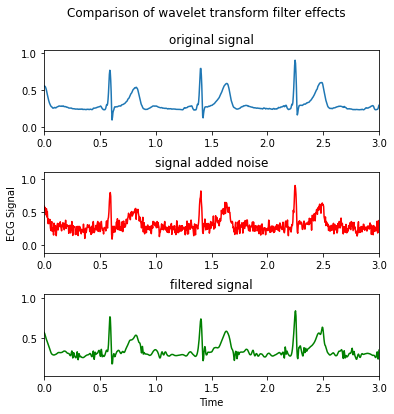

In [3]:
# show the plot of comparison
plt.figure(figsize=(6, 6))
plt.subplots_adjust(hspace=0.5)

# transform to time domain x axis
t = np.arange(len(ecg)) / float(sample_rate)
axis_1 = plt.subplot(311)
axis_1.set_title("original signal")
axis_1.set_xlim(0, 3)
axis_1.plot(t, data)

axis_2 = plt.subplot(312)
axis_2.set_ylabel("ECG Signal")
axis_2.set_title("signal added noise")
axis_2.set_xlim(0, 3)
axis_2.plot(t, noised_data, color='r')

axis_3 = plt.subplot(313)
axis_3.set_xlabel('Time')
axis_3.set_title("filtered signal")
axis_3.set_xlim(0, 3)
axis_3.plot(t, filtered, color='g')

plt.suptitle("Comparison of wavelet transform filter effects")


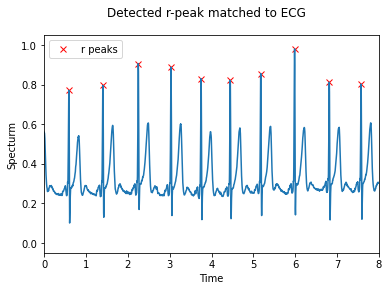

In [4]:
max_bpm = 150
spot = detect(ecg, sample_rate, max_bpm)
spot_t = []
spot_r = []
for i in spot:
    spot_t.append(t[i])
for i in spot:
    spot_r.append(ecg[i])
plt.xlim(0, 8)
plt.plot(spot_t, spot_r, 'x', color='r', label='r peaks')
plt.plot(t, ecg)
plt.xlabel("Time")
plt.ylabel("Specturm")
plt.suptitle("Detected r-peak matched to ECG")
plt.legend()


In [5]:
max_level = pw.swt_max_level(len(ecg))
(cA4, cD4), (cA3, cD3), (cA2, cD2), (cA1, cD1) = pw.swt(data, wavelet="haar", level=max_level)

Text(0.5, 0.98, 'Detail Coefficents Use Haar Wavelet Base')

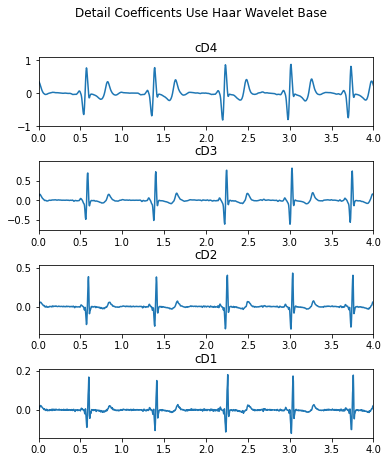

In [6]:
plt.figure(figsize=(6, 7))
plt.subplots_adjust(hspace =0.5)
plt.subplot(411)
plt.xlim(0, 4)
plt.title("cD4")
plt.plot(t, cD4)

plt.subplot(412)
plt.xlim(0, 4)
plt.title("cD3")
plt.plot(t, cD3)

plt.subplot(413)
plt.xlim(0, 4)
plt.title("cD2")
plt.plot(t, cD2)

plt.subplot(414)
plt.xlim(0, 4)
plt.title("cD1")
plt.plot(t, cD1)

plt.suptitle("Detail Coefficents Use Haar Wavelet Base")


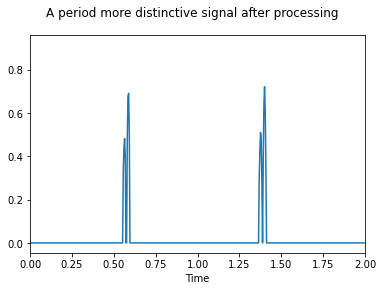

In [7]:
# make signal more significant
avg = np.mean(cD3)
std = np.std(cD3)
# add threshold
sig_thres = [abs(i) if abs(i) > 2.0 * std else 0 for i in cD3 - avg]
plt.xlim(0, 2)
plt.xlabel("Time")
plt.suptitle("A period more distinctive signal after processing")
plt.plot(t, sig_thres)


In [8]:
# init data input
input = []
hrv_class = HRV(250)

In [9]:
# cal all eigenvalues of each group of data from 0 - 19, and reshape list to ndarray
for i in range(20):
    data = pd.read_excel("data.xlsx", sheet_name=str(i) + "-maths",
                         header=0, usecols="B:F")
    data = data[0]
    data = (data - min(data)) / (max(data) - min(data))
    filtered = filter.wavelet_filtering(data)
    spot = detect(filtered, sample_rate, max_bpm)
    input.append(hrv_class.pNN50(spot))
    input.append(hrv_class.RMSSD(spot, normalise=True))
    input.append(hrv_class.SDNN(spot, normalise=True))
    data = pd.read_excel("data.xlsx", sheet_name=str(i) + "-sitting",
                         header=0, usecols="B:F")
    data = data[0]
    data = (data - min(data)) / (max(data) - min(data))
    filtered = filter.wavelet_filtering(data)
    spot = detect(filtered, sample_rate, max_bpm)
    input.append(hrv_class.pNN50(spot))
    input.append(hrv_class.RMSSD(spot, normalise=True))
    input.append(hrv_class.SDNN(spot, normalise=True))

f_input = np.array(input).reshape(40, 3)

D:\Scoop\apps\anaconda3\current\lib\site-packages\pandas\io\excel\_base.py:1272: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  return self._reader.parse(


In [10]:
# init target list and reshape it, list values corresponding to the label of data
# "sitting" - 0 , "maths" - 1
f_target = []
for i in range(20):
    f_target.append([1])
    f_target.append([0])
f_target = np.array(f_target).reshape(40, 1)

In [11]:
# use bpnn module to train and get weight matrix to predict
from bp_neural_network import BPNN
bp_instance = BPNN()
bp_instance.setup(3, 3, 1)
bp_instance.train(f_input, f_target, 20000, 0.2, 0.1)

In [12]:
# init test eigenvalues list
test = []
# count all wrong predictions
sum = 0
# init and reshape expected list
test_comparision = []
for i in range(5):
    test_comparision.append(0)
    test_comparision.append(1)
test_comparision = np.array(test_comparision).reshape(10, 1)

In [13]:
# Prediction and validation using data from 19 - 24
for i in range(5):
    file_no = i + 20
    data = pd.read_excel("data.xlsx", sheet_name=str(file_no) + "-sitting",
                        header=0, usecols="B:F")
    data = data[0]
    data = (data - min(data)) / (max(data) - min(data))
    filtered = filter.wavelet_filtering(data)
    spot = detect(filtered, sample_rate, max_bpm)
    test.append(hrv_class.pNN50(spot))
    test.append(hrv_class.RMSSD(spot, normalise=True))
    test.append(hrv_class.SDNN(spot, normalise=True))
    # use '^' to get catch wrong prediction result, same below
    data = pd.read_excel("data.xlsx", sheet_name=str(file_no) + "-maths",
                         header=0, usecols="B:F")
    data = data[0]
    data = (data - min(data)) / (max(data) - min(data))
    filtered = filter.wavelet_filtering(data)
    spot = detect(filtered, sample_rate, max_bpm)
    test.append(hrv_class.pNN50(spot))
    test.append(hrv_class.RMSSD(spot, normalise=True))
    test.append(hrv_class.SDNN(spot, normalise=True))
test = np.array(test).reshape(10, 3)


In [14]:
# compare expected result with predictions
for i in range(5):
    sum += 0 ^ (1 if (bp_instance.predict(test[i * 2])[0]) > 0.5 else 0)
    sum += 1 ^ (1 if (bp_instance.predict(test[i * 2 + 1])[0]) > 0.5 else 0)

In [15]:
# get correction rate
print(str((10 - sum) / 10 * 100) + "%")

70.0%


----

In [2]:
# get all original values
import data_preparation as dp
values = dp.cal_all_eigen_values()
# list to array
values = np.array(values)

D:\Scoop\apps\anaconda3\current\lib\site-packages\pandas\io\excel\_base.py:1272: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  return self._reader.parse(


KeyboardInterrupt: 

In [240]:
# normalise values
normalized = []
for i in range(7):
    outer = values[..., i]
    avg = np.mean(outer)
    std = np.std(outer)
    for j in values[..., i]:
        normalized.append((j - avg) / std)

In [241]:
# transform
normalized =  np.array(normalized).reshape(7, 50).T
# df = pd.DataFrame(normalized)
# columns = ['pNN50', 'RMSSD', 'HR_mean', 'HR_std', 'lfhf', 'lf', 'hf']
# df.columns = columns

In [158]:
# save to files
df.to_csv("norm_eigen_maxmin.csv", index_label="group_name")

In [3]:
data_labeld = np.loadtxt("norm_eigen_z_labeled.csv",
                         delimiter=",", dtype=np.float32)

In [4]:
bp_in = data_labeld[:34, :7]
bp_in

array([[ 2.30681434e-01, -1.69475257e-01, -8.27837646e-01,
        -3.59220415e-01, -6.55712128e-01, -1.61940783e-01,
         4.65623677e-01],
       [ 9.43317235e-01, -1.11835646e-02, -7.43610501e-01,
        -3.67657244e-01, -7.07884848e-01,  5.08130118e-02,
         8.61457705e-01],
       [ 1.18540347e+00,  1.44688272e+00,  1.80382264e+00,
         2.80372429e+00, -9.52913344e-01, -8.37157071e-01,
         1.04779208e+00],
       [-2.60246813e-01,  2.14534253e-01,  1.71460807e+00,
         7.17519820e-01, -1.13956356e+00, -1.83096874e+00,
         2.74793386e-01],
       [ 3.32675278e-01, -9.56758931e-02, -6.16589427e-01,
        -2.98642904e-01, -3.78281802e-01,  1.59753191e+00,
         9.98801827e-01],
       [ 3.73897463e-01, -1.50975212e-01, -2.26568490e-01,
        -3.17205995e-01, -8.59120250e-01,  4.15890180e-02,
         1.70130408e+00],
       [-1.51860923e-01, -2.66844600e-01, -5.74923098e-01,
        -2.82327861e-01,  4.16578382e-01,  4.15590554e-02,
        -6.9303149

In [5]:
bp_out = []
for i in range(17):
    bp_out.append([0, 1])
    bp_out.append([1, 0])
np.array(bp_out).reshape(34, 2)

array([[0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0]])

In [6]:
from bp_neural_network import BPNN
bp_class = BPNN()
bp_class.setup(7, 12, 2)
loss, acc_rate = bp_class.train(bp_in, bp_out, 10000, 0.2, 0.1)

In [163]:
sum = 0
for i in range(len(bp_in)):
    amout = np.abs(np.array(bp_class.predict(bp_in[i])) - bp_out[i]).sum()
    if amout > 0.5:
        sum += 1
        print(i)

18


In [164]:
predict_in = normalized[34:]
predict_out = []
for i in range(8):
    predict_out.append([0, 1])
    predict_out.append([1, 0])
np.array(predict_out).reshape(16, 2)

array([[0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0]])

In [165]:
sum = 0
for i in range(len(predict_in)):
    amout = np.abs(np.array(bp_class.predict(predict_in[i])) - predict_out[i]).sum()
    if amout > 1:
        sum += 1
        print(i)
sum

1
2
3
5
7
8
10
15


8

In [168]:
bp_class.predict(predict_in[7])

[0.0385141212677353, 0.9622894564483403]

---

In [229]:
normalized_labeled = []
for i in range(50):
    if(i % 2 == 0):
        label = [1, 0]
    else:
        label = [0, 1]
    normalized_labeled.append(normalized[i].tolist() + label)
np.array(normalized_labeled)

array([[ 2.30681430e-01, -1.69475263e-01, -8.27837651e-01,
        -3.59220406e-01, -6.55712148e-01, -1.61940787e-01,
         4.65623672e-01,  1.00000000e+00,  0.00000000e+00],
       [ 9.43317222e-01, -1.11835643e-02, -7.43610517e-01,
        -3.67657256e-01, -7.07884845e-01,  5.08130108e-02,
         8.61457706e-01,  0.00000000e+00,  1.00000000e+00],
       [ 1.18540347e+00,  1.44688274e+00,  1.80382268e+00,
         2.80372428e+00, -9.52913353e-01, -8.37157042e-01,
         1.04779212e+00,  1.00000000e+00,  0.00000000e+00],
       [-2.60246804e-01,  2.14534257e-01,  1.71460807e+00,
         7.17519828e-01, -1.13956350e+00, -1.83096869e+00,
         2.74793397e-01,  0.00000000e+00,  1.00000000e+00],
       [ 3.32675284e-01, -9.56758921e-02, -6.16589425e-01,
        -2.98642891e-01, -3.78281811e-01,  1.59753191e+00,
         9.98801836e-01,  1.00000000e+00,  0.00000000e+00],
       [ 3.73897456e-01, -1.50975216e-01, -2.26568496e-01,
        -3.17206007e-01, -8.59120224e-01,  4.158901

In [230]:
np.savetxt("norm_eigen_z_labeled.csv", normalized_labeled, delimiter=",")

In [232]:
arrays = np.loadtxt("norm_eigen_z_labeled.csv", delimiter=",")

In [239]:
loss_minmax = loss

In [246]:
loss_z = loss

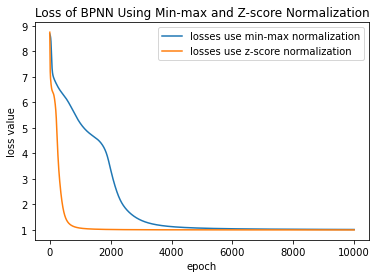

In [254]:
fig, ax = plt.subplots()
ax.plot(loss_minmax, label='losses use min-max normalization')
ax.plot(loss_z, label='losses use z-score normalization')
ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.set_title('Loss of BPNN Using Min-max and Z-score Normalization')
ax.legend()

In [11]:
pytorch_train_acc = np.loadtxt("train_acc.csv", delimiter=",", dtype=np.float32)

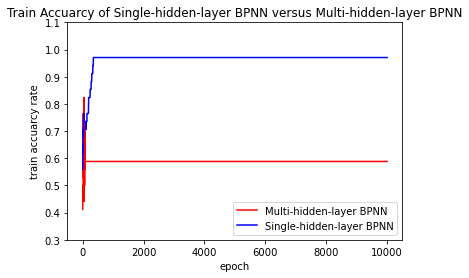

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(pytorch_train_acc, label='Multi-hidden-layer BPNN', color='red')
ax.plot(acc_rate, label='Single-hidden-layer BPNN', color = 'blue')
ax.set_ylim(0.3, 1.1)
ax.set_xlabel('epoch')
ax.set_ylabel('train accuarcy rate')
ax.set_title('Train Accuarcy of Single-hidden-layer BPNN versus Multi-hidden-layer BPNN')
ax.legend()
